# Enhanced MRI Data Visualization

This notebook includes advanced techniques to explore and analyze MRI data in NIfTI and DICOM formats.

In [3]:
!pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.5 MB/s eta 0:00:00


In [1]:


import nibabel as nib
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import imageio


## Load and Inspect NIfTI File

In [3]:
nifti_path = "sub-65304_ses-1_acq-t1csmp2ragesag06mmUNIDEN_T1w.nii"
nifti_img = nib.load(nifti_path)
nifti_data = nifti_img.get_fdata()
nifti_affine = nifti_img.affine
nifti_header = nifti_img.header

print("NIfTI shape:", nifti_data.shape)
print("Voxel dimensions:", nifti_header.get_zooms())
print("Affine matrix:\n", nifti_affine)


NIfTI shape: (256, 384, 384)
Voxel dimensions: (np.float32(0.63), np.float32(0.625), np.float32(0.625))
Affine matrix:
 [[ 6.26228750e-01 -5.86845390e-02 -3.49271894e-02 -6.36599960e+01]
 [ 6.13057874e-02  6.20829523e-01  3.86882909e-02 -1.04477142e+02]
 [ 3.13100182e-02 -4.18554321e-02  6.22822821e-01 -1.21944519e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Load and Inspect DICOM File

In [4]:
dicom_path = "0002.DCM"
dicom_img = pydicom.dcmread(dicom_path)
dicom_data = dicom_img.pixel_array

print("DICOM image shape:", dicom_data.shape)
print("Patient Name:", dicom_img.get("PatientName", "N/A"))
print("Study Date:", dicom_img.get("StudyDate", "N/A"))
print("Modality:", dicom_img.get("Modality", "N/A"))
print("Pixel Spacing:", dicom_img.get("PixelSpacing", "N/A"))
print("Slice Thickness:", dicom_img.get("SliceThickness", "N/A"))
print("Image Position Patient:", dicom_img.get("ImagePositionPatient", "N/A"))


DICOM image shape: (96, 512, 512)
Patient Name: Rubo DEMO
Study Date: 19941013
Modality: XA
Pixel Spacing: N/A
Slice Thickness: N/A
Image Position Patient: N/A


## Interactive Slice Viewer

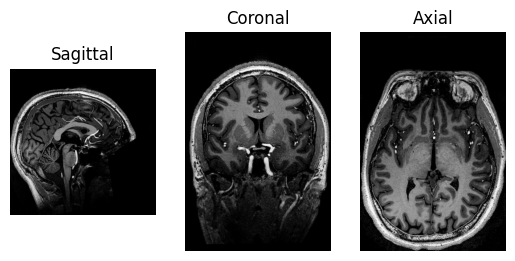

In [5]:

def show_slices(slices, titles):
    fig, axes = plt.subplots(1, len(slices))
    for i, (slice_, title) in enumerate(zip(slices, titles)):
        axes[i].imshow(slice_.T, cmap="gray", origin="lower")
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

slices = [
    nifti_data[nifti_data.shape[0]//2, :, :],  # Sagittal
    nifti_data[:, nifti_data.shape[1]//2, :],  # Coronal
    nifti_data[:, :, nifti_data.shape[2]//2]   # Axial
]
show_slices(slices, ["Sagittal", "Coronal", "Axial"])


In [6]:
def view_slices(volume):
    def show_slice(axis, idx):
        plt.figure(figsize=(5,5))
        if axis == 'axial':
            plt.imshow(volume[:, :, idx], cmap='gray')
        elif axis == 'coronal':
            plt.imshow(volume[:, idx, :], cmap='gray')
        elif axis == 'sagittal':
            plt.imshow(volume[idx, :, :], cmap='gray')
        plt.axis('off')
        plt.title(f"{axis.capitalize()} Slice {idx}")
        plt.show()

    axis_selector = widgets.Dropdown(options=['axial', 'coronal', 'sagittal'], description='Plane')
    slice_slider = widgets.IntSlider(min=0, max=volume.shape[2]-1, description='Slice')

    def update(change):
        slice_slider.max = volume.shape[{'sagittal':0, 'coronal':1, 'axial':2}[change['new']]] - 1

    widgets.interact(lambda axis, idx: show_slice(axis, idx),
                     axis=axis_selector, idx=slice_slider)
    axis_selector.observe(update, names='value')

view_slices(nifti_data)


interactive(children=(Dropdown(description='Plane', options=('axial', 'coronal', 'sagittal'), value='axial'), …

## Voxel Intensity Histogram

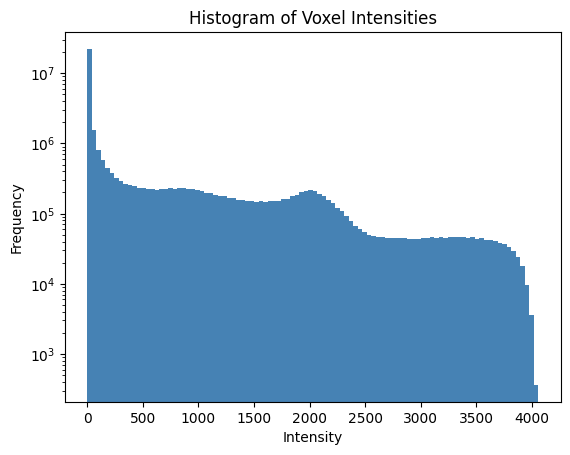

In [10]:
plt.hist(nifti_data.flatten(), bins=100, color='steelblue')
plt.title("Histogram of Voxel Intensities")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()


## 3D Volume Rendering (Plotly)
(not working due to ram storage issues)




In [ ]:
fig = go.Figure(data=go.Volume(
    x=np.linspace(0, 1, nifti_data.shape[0]).repeat(nifti_data.shape[1]*nifti_data.shape[2]),
    y=np.tile(np.linspace(0, 1, nifti_data.shape[1]).repeat(nifti_data.shape[2]), nifti_data.shape[0]),
    z=np.tile(np.linspace(0, 1, nifti_data.shape[2]), nifti_data.shape[0]*nifti_data.shape[1]),
    value=nifti_data.flatten(),
    isomin=50,
    isomax=200,
    opacity=0.1,
    surface_count=10
))
fig.update_layout(title='3D Volume Rendering', width=700, height=700)
fig.show()


# Stack Multiple DICOM Slices into 3D Volume

In [ ]:

def load_dicom_series(folder):
    slices = [pydicom.dcmread(f) for f in sorted(glob(os.path.join(folder, "*.DCM")))]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    volume3d = np.zeros(img_shape, dtype=np.int16)
    for i, s in enumerate(slices):
        volume3d[:, :, i] = s.pixel_array
    return volume3d, slices

dicom_volume, dicom_slices = load_dicom_series("DICOM_Series")
print("Volume shape:", dicom_volume.shape)


#Image Orientation Interpretation

In [9]:

print("NIfTI Affine Matrix:\n", nifti_affine)
print("\nThis matrix helps map voxel coordinates to world (RAS) space.")

orientation = nib.aff2axcodes(nifti_affine)
print("NIfTI Orientation (axcodes):", orientation)


NIfTI Affine Matrix:
 [[ 6.26228750e-01 -5.86845390e-02 -3.49271894e-02 -6.36599960e+01]
 [ 6.13057874e-02  6.20829523e-01  3.86882909e-02 -1.04477142e+02]
 [ 3.13100182e-02 -4.18554321e-02  6.22822821e-01 -1.21944519e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

This matrix helps map voxel coordinates to world (RAS) space.
NIfTI Orientation (axcodes): ('R', 'A', 'S')


#DICOM vs NIfTI Comparison

| Aspect                  | **DICOM**                                                                   | **NIfTI**                                                     |
| ----------------------- | --------------------------------------------------------------------------- | ------------------------------------------------------------- |
| **Orientation Source**  | Uses `ImagePositionPatient` and `ImageOrientationPatient` DICOM tags        | Uses the **affine transformation matrix** in the header       |
| **Per-Slice Control**   | Orientation is defined **per slice**, since each `.dcm` file is independent | Orientation is **uniform across the whole volume**            |
| **Axes Meaning**        | Patient-centric: describes position relative to head/feet, left/right       | Scanner-centric: affine defines voxel-to-world transformation |
| **Handling Complexity** | Complex to reconstruct correctly without sorting and alignment logic        | Easier; affine handles full 3D alignment automatically        |
| **Sorting Required**    | Must sort slices using `InstanceNumber` or `ImagePositionPatient[2]`        | Not required — data is already stacked in one 3D array        |


| Feature                   | **DICOM**                                       | **NIfTI**                                       |
| ------------------------- | ----------------------------------------------- | ----------------------------------------------- |
| **Primary Use**           | Clinical workflows (radiology, PACS)            | Research and neuroscience (fMRI, brain studies) |
| **Metadata Structure**    | Extensive per-slice metadata in nested tags     | Minimal, structured header metadata per volume  |
| **File Format**           | One `.dcm` file per 2D slice                    | Single `.nii` or `.nii.gz` file per 3D/4D scan  |
| **Compression**           | Usually uncompressed or JPEG-based              | Can be compressed as `.nii.gz`                  |
| **Ease of Use in Python** | Requires sorting, alignment, multiple libraries | Simple with `nibabel` or `SimpleITK`            |
| **Standardization**       | Variable across manufacturers                   | Standard and consistent across platforms        |
| **Visualization Tools**   | Requires per-slice assembly                     | Direct 3D access, ideal for visualization       |
| **File Size (per study)** | Larger (many files)                             | Smaller and more portable                       |
